In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

import pickle

In [2]:
dataset = 'PGE-CSI-00114'

with open('pickles/data_'+dataset+'.pickle', 'rb') as to_read:
    data = pickle.load(to_read)

In [3]:
data.shape

(210432, 8)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210432 entries, 0 to 210431
Data columns (total 8 columns):
LocalTime    210432 non-null object
kWh          210432 non-null float64
date_time    210432 non-null datetime64[ns]
date         210432 non-null datetime64[ns]
year         210432 non-null int64
month        210432 non-null int64
day          210432 non-null int64
time         210432 non-null object
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 12.8+ MB


In [5]:
data.head(5)

,LocalTime,kWh,date_time,date,year,month,day,time
0,01/01/2011 0:00:00,0.0,2011-01-01 00:00:00,2011-01-01,2011,1,1,00:00
1,01/01/2011 0:15:00,0.0,2011-01-01 00:15:00,2011-01-01,2011,1,1,00:15
2,01/01/2011 0:30:00,0.0,2011-01-01 00:30:00,2011-01-01,2011,1,1,00:30
3,01/01/2011 0:45:00,0.0,2011-01-01 00:45:00,2011-01-01,2011,1,1,00:45
4,01/01/2011 1:00:00,0.0,2011-01-01 01:00:00,2011-01-01,2011,1,1,01:00


### Modeling:
time horizon:<br>
option 1: train on full year 2015 based on 2011-2014, test on 2016<br>
option 2: train on july 2015 based on july 2014- june 2015, test on august 2016<br>
<br>
interval:<br>
option 1: hourly (forecast next day)<br>
option 2: 15 minutes (forecast x hours - this usually involves more weather imaging)<br>

### Model:
time horizon: multiyear; hourly

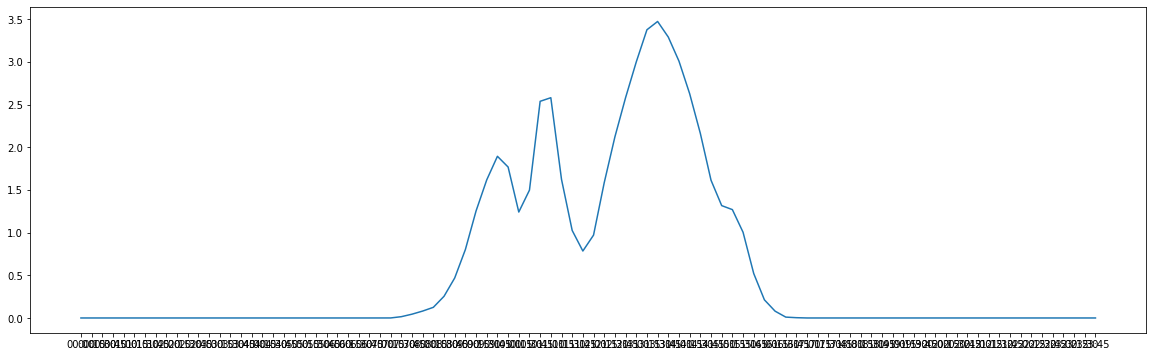

In [6]:
plt.figure(figsize=(20,6))
plt.plot(data['time'][data['date']=='2015-01-04'],data['kWh'][data['date']=='2015-01-04']);

### options to remove night hours:
- remove all times with zero output <br>
- remove specified time range (eg 5am-8pm) <br>
- remove specific time range based on sunrise-sunset <br>

## v1: multi-year model, predict full year

In [7]:
# subset training and test data
data_train = data[(data['year'] >= 2011) & (data['year']<=2015)]
data_test = data[data['year']==2016]

In [8]:
data_train.shape

(175296, 8)

In [9]:
data_test.shape

(35136, 8)

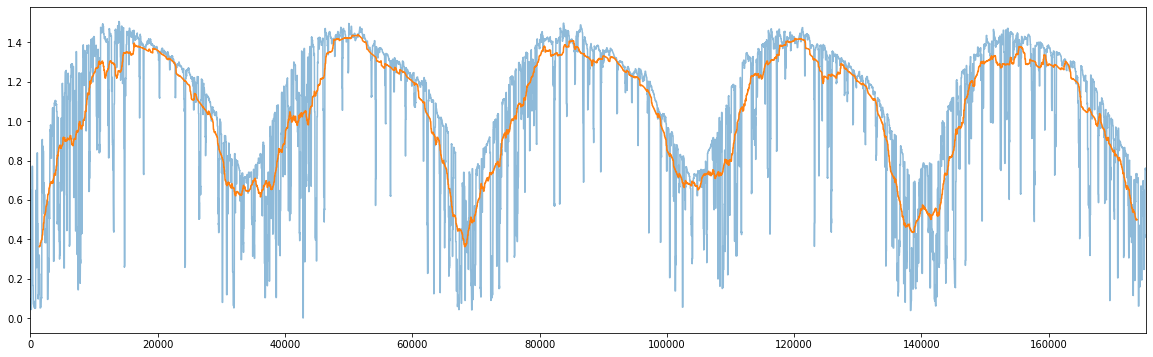

In [10]:
data_train['kWh'].rolling(96,center=True).mean().plot(figsize=(20,6),alpha=0.5);
data_train['kWh'].rolling(2880,center=True).mean().plot(figsize=(20,6),alpha=1);

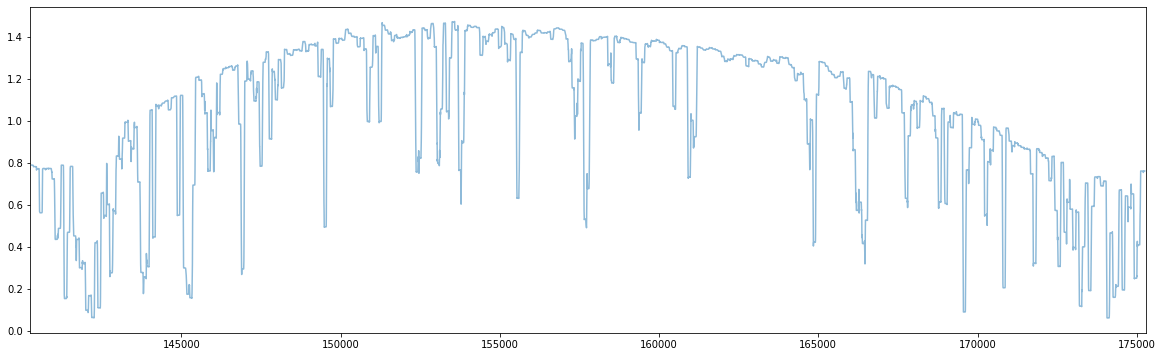

In [11]:
data_train['kWh'][data_train['year']==2015].rolling(96,center=True).mean().plot(figsize=(20,6),alpha=0.5);

In [12]:
# consolidate to hours
data_train0 = data_train['kWh']
# .reindex(data_train['date_time'], fill_value=0)
data_train0.index = data_train['date_time']

In [13]:
data_train0.describe()

count    175296.000000
mean          1.049764
std           1.566958
min           0.000000
25%           0.000000
50%           0.001510
75%           2.177570
max           4.959450
Name: kWh, dtype: float64

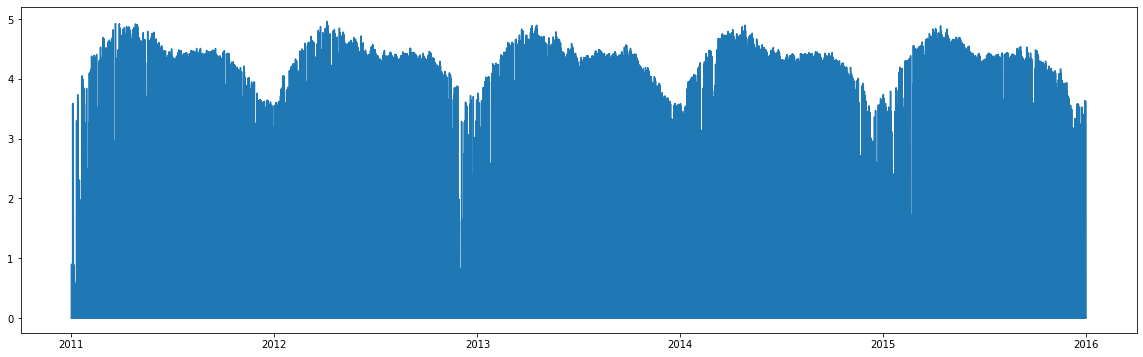

In [14]:
plt.figure(figsize=(20,6))
plt.plot(data_train0);

In [15]:
data_train0 = data_train0.resample('H').sum()
print('Hourly Output')
print(data_train0.head(), '\n')
data_train0.shape

Hourly Output
date_time
2011-01-01 00:00:00    0.0
2011-01-01 01:00:00    0.0
2011-01-01 02:00:00    0.0
2011-01-01 03:00:00    0.0
2011-01-01 04:00:00    0.0
Freq: H, Name: kWh, dtype: float64 



(43824,)

In [16]:
# do same for test
data_test0 = data_test['kWh']
# .reindex(data_train['date_time'], fill_value=0)
data_test0.index = data_test['date_time']

data_test0 = data_test0.resample('H').sum()
print('Hourly Output')
print(data_test0.head(), '\n')
data_test0.shape

Hourly Output
date_time
2016-01-01 00:00:00    0.0
2016-01-01 01:00:00    0.0
2016-01-01 02:00:00    0.0
2016-01-01 03:00:00    0.0
2016-01-01 04:00:00    0.0
Freq: H, Name: kWh, dtype: float64 



(8784,)

In [17]:
# remove nighttime hours - this doesn't give equal time periods for each day though
data_train1 = data_train0[data_train0!=0]
print(data_train1.shape)
data_test1 = data_test0[data_test0!=0]
print(data_test1.shape)

(23593,)
(4744,)


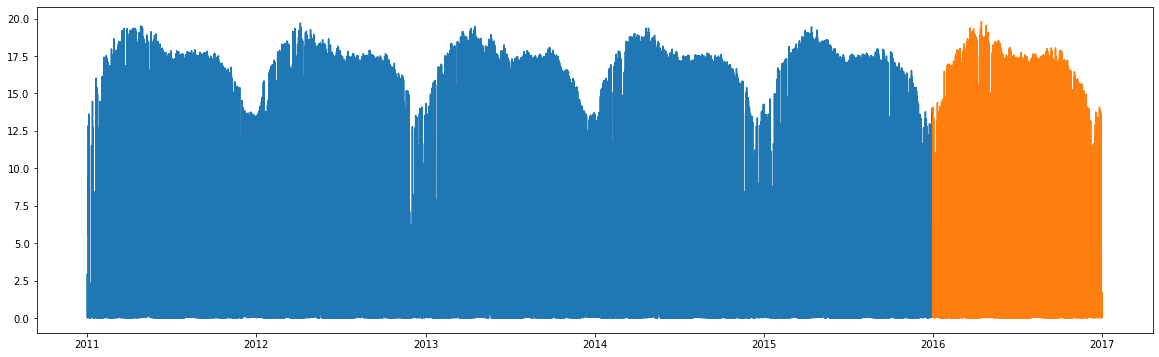

In [18]:
plt.figure(figsize=(20,6))
# plt.plot(data_train1[data_train1.index.year==2015]);
plt.plot(data_train1)
plt.plot(data_test1);

In [19]:
data_train1[500:524]

date_time
2011-02-17 07:00:00    0.29677
2011-02-17 08:00:00    2.37497
2011-02-17 09:00:00    8.56952
2011-02-17 10:00:00    6.33135
2011-02-17 11:00:00    6.15137
2011-02-17 12:00:00    6.36725
2011-02-17 13:00:00    3.89944
2011-02-17 14:00:00    1.83721
2011-02-17 15:00:00    1.35429
2011-02-17 16:00:00    0.11440
2011-02-17 17:00:00    0.00487
2011-02-18 06:00:00    0.00005
2011-02-18 07:00:00    0.29815
2011-02-18 08:00:00    2.14157
2011-02-18 09:00:00    6.60049
2011-02-18 10:00:00    7.34112
2011-02-18 11:00:00    4.13232
2011-02-18 12:00:00    1.81606
2011-02-18 13:00:00    3.54746
2011-02-18 14:00:00    3.84563
2011-02-18 15:00:00    1.01940
2011-02-18 16:00:00    0.19604
2011-02-18 17:00:00    0.06728
2011-02-19 06:00:00    0.00288
Name: kWh, dtype: float64

### Test for stationarity

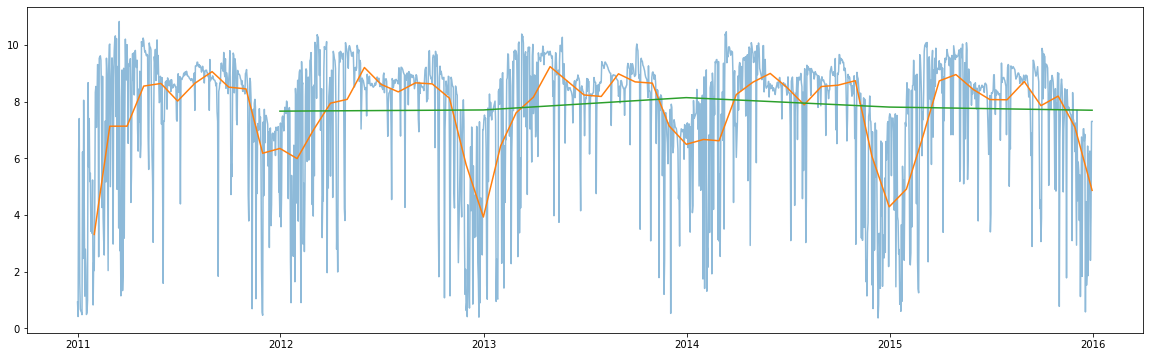

In [20]:
data_daily = data_train1.resample('D').mean()
data_monthly = data_train1.resample('M').mean()
data_annual = data_train1.resample('A').mean()

plt.figure(figsize=(20,6))
plt.plot(data_daily,alpha=0.5)
plt.plot(data_monthly)
plt.plot(data_annual);

In [21]:
# check daily deviations for various diffs
print(data_daily.std())
print(data_daily.diff().std()) # seems to be the best -difference once
print(data_daily.diff().diff().std())
print(data_daily.diff().diff().diff().std())

2.2343723472773656
2.125268823718178
3.5367378397590836
6.371951145413445


In [22]:
# check monthly deviations for various diffs
print(data_monthly.std())
print(data_monthly.diff().std())
print(data_monthly.diff().diff().std())
print(data_monthly.diff().diff().diff().std())

1.3795274747045099
1.1668849059284554
1.369291025675047
2.1299819769860764


In [23]:
# check annual deviations for various diffs
print(data_annual.std())
print(data_annual.diff().std())
print(data_annual.diff().diff().std())
print(data_annual.diff().diff().diff().std())

0.19645773056398516
0.3236445640040273
0.626942403618021
1.5212581365954476


In [24]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic          -1.362340
p-value                  0.600192
Lags Used               11.000000
Observations Used       48.000000
Critical Value (1%)     -3.574589
Critical Value (5%)     -2.923954
Critical Value (10%)    -2.600039
dtype: float64


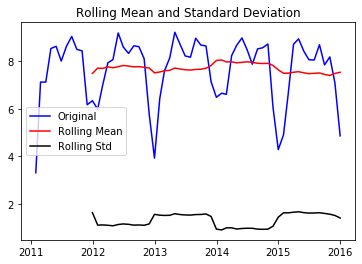

In [25]:
# run DFT on monthly
dftest(data_monthly)
# p-value allows us to reject a unit root: data is stationary

In [26]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data_monthly)
print(adf)
print(pvalue)
print(usedlag)

-1.3623396044480247
0.6001919774661674
11


### Decomposition

In [27]:
data_train1.shape

(23593,)

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=data_train1, model='multiplicative', freq=9000) # what is freq supposed to be?
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

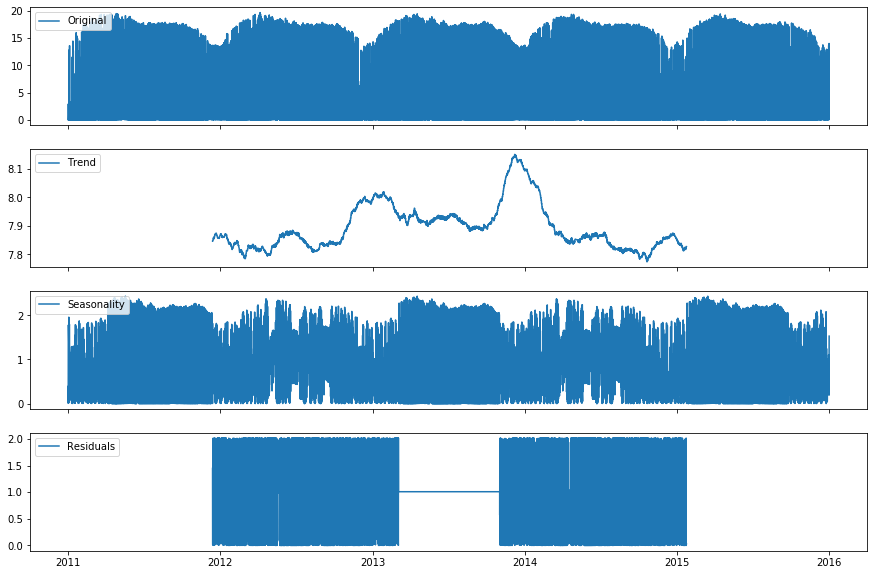

In [29]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(data_train1, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

### Smoothing
- do I need to smooth? the fluctuations should represent the time of day

In [30]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [31]:
def moving_average(observations, window=3, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(3))
    else:
        return cumulative_sum[window - 1:] / window

In [32]:
smoothed_data = moving_average(data_train1.values, window=5, forecast=False)

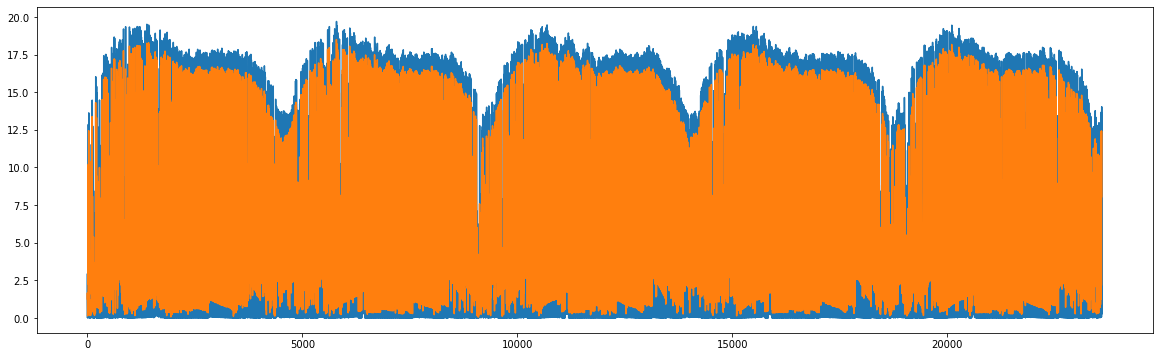

In [33]:
plt.figure(figsize=(20,6))
plt.plot(data_train1.values)
plt.plot(smoothed_data);

In [34]:
# save w/ nighttime hours
with open('pickles/data_'+dataset+'_train0.pickle', 'wb') as to_write:
    pickle.dump(data_train0, to_write)
with open('pickles/data_'+dataset+'_test0.pickle', 'wb') as to_write:
    pickle.dump(data_test0, to_write)
    
#save w/o nighttime hours
with open('pickles/data_'+dataset+'_train1.pickle', 'wb') as to_write:
    pickle.dump(data_train1, to_write)
with open('pickles/data_'+dataset+'_test1.pickle', 'wb') as to_write:
    pickle.dump(data_test1, to_write)